<ipython-input-28-ee03cefb8793>:34: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  reward_psnr = psnr(self.current_image, self.image)
<ipython-input-28-ee03cefb8793>:123: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = torch.nn.functional.mse_loss(q_values, torch.tensor([reward], dtype=torch.float32))


PNR Ratio: 0.0030
PNR Ratio: 0.0030
PNR Ratio: 0.0030
PNR Ratio: 0.0030
PNR Ratio: 0.0031


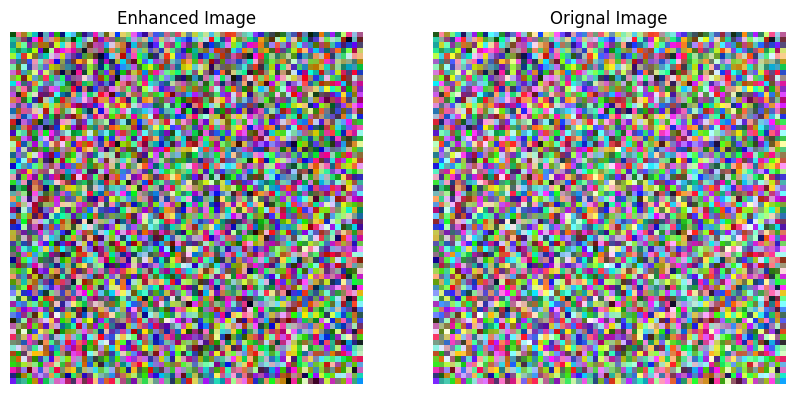

Total reward for this episode: 5.44


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

# Generate a random image (64x64 with 3 color channels, as in RGB)
def generate_random_image():
    return np.random.randint(0, 256, (64, 64, 3), dtype=np.uint8)

# Simulate some "enhancement" actions on the image
def apply_enhancement(image, action):
    if action == 0:
        # Simulate Gaussian blur by reducing pixel intensity randomly
        enhanced_image = np.clip(image - np.random.randint(0, 10, image.shape), 0, 255)
    elif action == 1:
        # Simulate contrast adjustment by increasing pixel intensity randomly
        enhanced_image = np.clip(image + np.random.randint(0, 10, image.shape), 0, 255)
    return enhanced_image

# Define the environment as a simple class
class SimpleImageEnhancementEnv:
    def __init__(self, image):
        self.image = image  # Original low-resolution image
        self.current_image = image.copy()
        self.action_space = 2  # Two actions: Blur and Contrast adjustment

    def step(self, action):
        # Apply the chosen enhancement action
        self.current_image = apply_enhancement(self.current_image, action)

        # Calculate PSNR between the enhanced and original image
        reward_psnr = psnr(self.current_image, self.image)

        # Calculate PNR ratio
        pnr_ratio = 1 / (1 + np.abs(reward_psnr - 30))  # Example PNR ratio; adjust as needed

        # Print the PNR ratio for debugging
        print(f"PNR Ratio: {pnr_ratio:.4f}")  # Printing PNR Ratio

        # Calculate the final reward based on PSNR and PNR ratio
        final_reward = reward_psnr * pnr_ratio

        done = False  # Since this is a simple simulation, we'll not define a done condition

        return self.current_image, final_reward, done

    def reset(self):
        # Reset to the original image
        self.current_image = self.image.copy()
        return self.current_image

# Define a simple DQN network
class SimpleDQN(nn.Module):
    def __init__(self):
        super(SimpleDQN, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, 128)  # Input layer (flattened image)
        self.fc2 = nn.Linear(128, 64)           # Hidden layer
        self.fc3 = nn.Linear(64, 2)             # Output layer (2 actions: Blur, Contrast adjustment)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Return action scores

# Initialize the DQN agent and optimizer
agent = SimpleDQN()
optimizer = optim.Adam(agent.parameters(), lr=0.001)

# Function to display images before and after enhancement
def plot_images(original_image, enhanced_image, episode):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Orignal
    axes[1].imshow(enhanced_image)
    axes[1].set_title(f'Orignal Image')
    axes[1].axis('off')

    # Enhanched
    axes[0].imshow(original_image)
    axes[0].set_title('Enhanced Image')
    axes[0].axis('off')



    plt.show()

# Simulate one episode for demonstration
def run_episode():
    # Generate a random image to simulate the input image
    original_image = generate_random_image()

    # Initialize the environment with this image
    env = SimpleImageEnhancementEnv(original_image)

    # Reset the environment (get the starting state, which is the original image)
    state = env.reset()

    total_reward = 0
    done = False
    steps = 5  # We'll limit the episode to 5 steps for this example

    for step in range(steps):
        # Convert the state (image) to a tensor and add a batch dimension
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Get Q-values from the agent's network
        q_values = agent(state_tensor)

        # Select the action with the highest Q-value
        action = torch.argmax(q_values).item()

        # Step the environment using the selected action
        next_state, reward, done = env.step(action)

        # Accumulate the reward
        total_reward += reward

        # Calculate the loss (we'll assume the reward is the target Q-value for simplicity)
        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(q_values, torch.tensor([reward], dtype=torch.float32))
        loss.backward()
        optimizer.step()

        # Update the state
        state = next_state

    # Plot the original and enhanced images
    plot_images(original_image, env.current_image, episode=1)

    print(f"Total reward for this episode: {total_reward:.2f}")

# Run the simulation
run_episode()


PNR Ratio: 0.2298
PNR Ratio: 0.0595
PNR Ratio: 0.0582
PNR Ratio: 0.0567
PNR Ratio: 0.0573


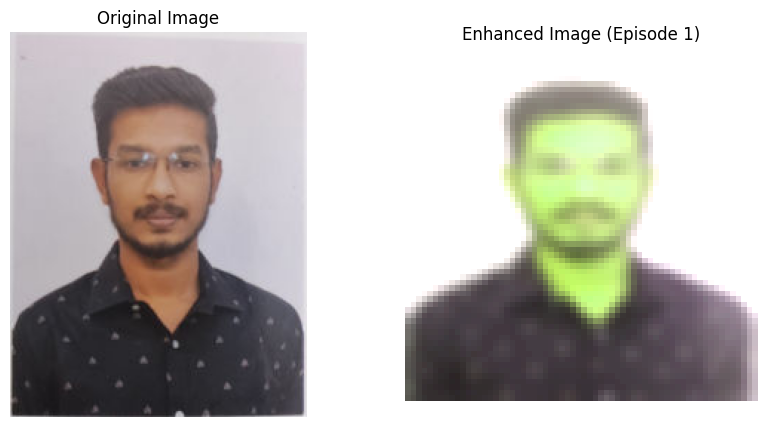

Total reward for this episode: 9.31


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load a specific image from file
def load_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image not found at path: {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Resize image to 64x64 pixels
def resize_image(image, size=(64, 64)):
    return cv2.resize(image, size)

# Simulate some "enhancement" actions on the image
def apply_enhancement(image, action):
    if action == 0:
        # Simulate Gaussian blur
        enhanced_image = cv2.GaussianBlur(image, (5, 5), 0)
    elif action == 1:
        # Simulate contrast adjustment
        enhanced_image = cv2.convertScaleAbs(image, alpha=1.5, beta=0)  # Increase contrast
    elif action == 2:
        # Simulate brightness increase
        enhanced_image = cv2.convertScaleAbs(image, alpha=1, beta=50)  # Increase brightness
    elif action == 3:
        # Simulate sharpening
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        enhanced_image = cv2.filter2D(image, -1, kernel)  # Sharpening filter
    elif action == 4:
        # Simulate color adjustment (Hue)
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hsv[..., 0] = (hsv[..., 0] + 10) % 180  # Adjust hue
        enhanced_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return enhanced_image

# Define the environment for image enhancement
class SimpleImageEnhancementEnv:
    def __init__(self, image):
        self.image = image  # Original low-resolution image
        self.current_image = image.copy()
        self.action_space = 5  # Five actions defined now

    def step(self, action):
        # Apply the chosen enhancement action
        self.current_image = apply_enhancement(self.current_image, action)

        # Calculate PSNR between the enhanced and original image
        reward_psnr = psnr(self.current_image, self.image)

        # Calculate PNR ratio
        pnr_ratio = 1 / (1 + np.abs(reward_psnr - 30))  # Example PNR ratio; adjust as needed

        # Print the PNR ratio for debugging
        print(f"PNR Ratio: {pnr_ratio:.4f}")  # Printing PNR Ratio

        # Calculate the final reward based on PSNR and PNR ratio
        final_reward = reward_psnr * pnr_ratio

        done = False  # Since this is a simple simulation, we'll not define a done condition

        return self.current_image, final_reward, done

    def reset(self):
        # Reset to the original image
        self.current_image = self.image.copy()
        return self.current_image

# Define a simple DQN network
class SimpleDQN(nn.Module):
    def __init__(self):
        super(SimpleDQN, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, 128)  # Input layer (flattened image)
        self.fc2 = nn.Linear(128, 64)           # Hidden layer
        self.fc3 = nn.Linear(64, 5)             # Output layer (5 actions)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the image using reshape
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Return action scores

# Initialize the DQN agent and optimizer
agent = SimpleDQN()
optimizer = optim.Adam(agent.parameters(), lr=0.001)

# Function to display images before and after enhancement
def plot_images(original_image, enhanced_image, episode):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Enhanced image
    axes[1].imshow(enhanced_image)
    axes[1].set_title(f'Enhanced Image (Episode {episode})')
    axes[1].axis('off')

    plt.show()

# Simulate one episode for demonstration
def run_episode(image_path):
    # Load the specific image to enhance
    original_image = load_image(image_path)

    # Resize the image to 64x64 pixels
    resized_image = resize_image(original_image)

    # Initialize the environment with this image
    env = SimpleImageEnhancementEnv(resized_image)

    # Reset the environment (get the starting state, which is the original image)
    state = env.reset()

    total_reward = 0
    done = False
    steps = 5  # We'll limit the episode to 5 steps for this example

    for step in range(steps):
        # Convert the state (image) to a tensor and add a batch dimension
        state_tensor = torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Change to CxHxW

        # Get Q-values from the agent's network
        q_values = agent(state_tensor)

        # Select the action with the highest Q-value
        action = torch.argmax(q_values).item()

        # Step the environment using the selected action
        next_state, reward, done = env.step(action)

        # Accumulate the reward
        total_reward += reward

        # Calculate the loss (we'll assume the reward is the target Q-value for simplicity)
        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(q_values[0, action], torch.tensor(reward, dtype=torch.float32))
        loss.backward()
        optimizer.step()

        # Update the state
        state = next_state

    # Plot the original and enhanced images
    plot_images(original_image, env.current_image, episode=1)

    print(f"Total reward for this episode: {total_reward:.2f}")

# Specify the path to your image here
image_path = '/content/imresizer-1727365402663.jpg'  # Change this to the path of your image file

# Run the simulation
run_episode(image_path)


Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.4469
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.1037
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.1018
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0989
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0963
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 5 with shape: (64, 64, 3)


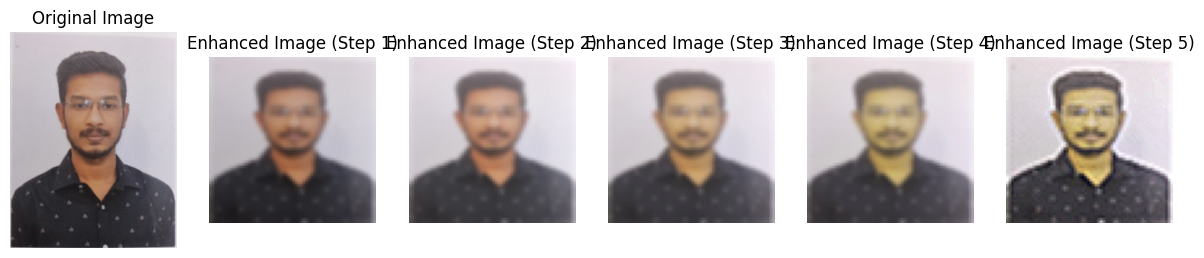

Total reward for episode 1: 21.28
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 5 with shape: (64, 64, 3)
Plotting enhanced image 6 with shape: (64, 64, 3)
Plotting enhanced image 7 with shape: (64, 64, 3)
Plotting enhanced image 8 with shape: (64, 64, 3)
Plotting enhanced image 9 with shape: (64, 64, 3)
Plotting enhanced image 10 with shape: (64, 64, 3)


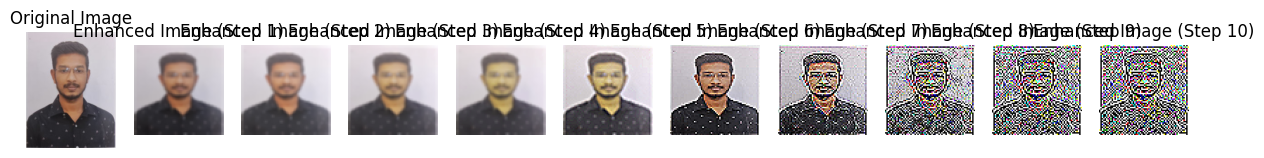

Total reward for episode 2: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0424
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0401
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 5 with shape: (64, 64, 3)
Plotting enhanced image 6 with shape: (64, 64, 3)
Plotting enhanced image 7 with shape: (64, 64, 3)
Plotting enhanced image 8 with shape: (64, 64, 3)
Plotting enhanced image 9 with shape: (64, 64, 3)
Plotting enhanced image 10 with sh

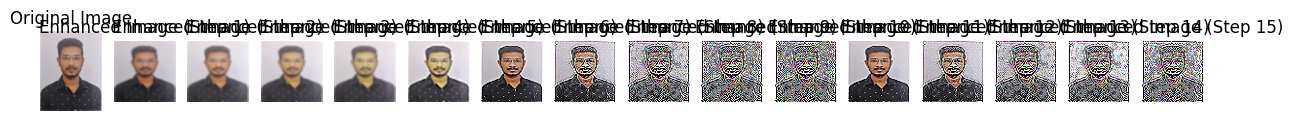

Total reward for episode 3: 3.07
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 5 with shape: (64, 64, 3)
Plotting enhanced image 6 with shape: (64, 64, 3)
Plotting enhanced image 7 with shape: (64, 64, 3)
Plotting enhanced image 8 with shape: (64, 64, 3)
Plotting enhanced i

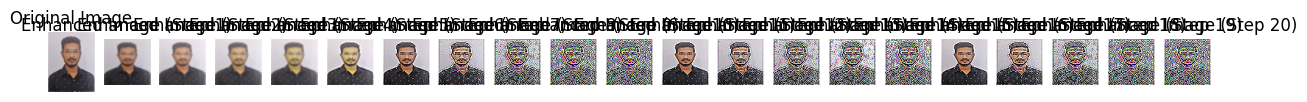

Total reward for episode 4: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 5 with shape: (64, 64, 3)
Plotting enhanced image 6 with shape: (64, 64, 3)
Plotting enhanced image 7 with shape: (64, 64, 3)
Plot

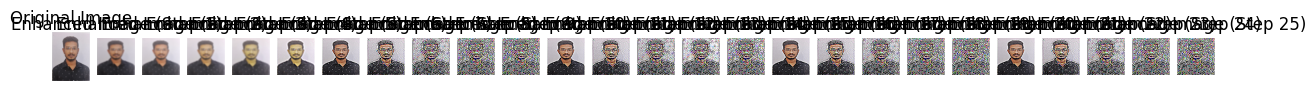

Total reward for episode 5: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 5 with shape: (64, 64, 3)
Plotting enhanced image 6 with shape: (

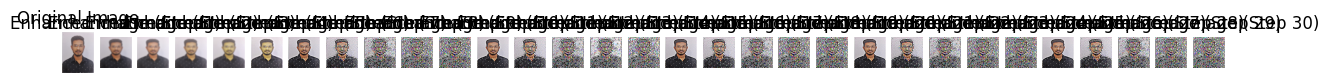

Total reward for episode 6: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting enhanced image 4 with shape: (64, 64, 3)
Plotting enhanced image 

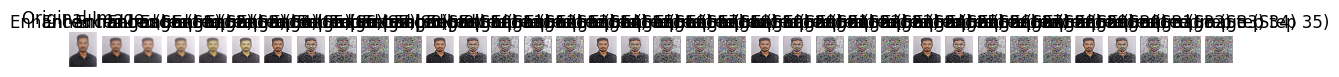

Total reward for episode 7: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 64, 3)
Plotting enhanced image 3 with shape: (64, 64, 3)
Plotting 

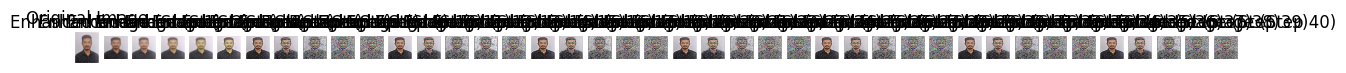

Total reward for episode 8: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 with shape: (64, 64, 3)
Plotting enhanced image 2 with shape: (64, 6

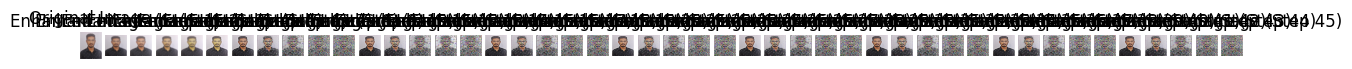

Total reward for episode 9: 2.97
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0819
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0534
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0425
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0399
Enhanced Image Shape: (64, 64, 3)
PNR Ratio: 0.0395
Shapes of enhanced images: [(64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3), (64, 64, 3)]
Plotting enhanced image 1 wit

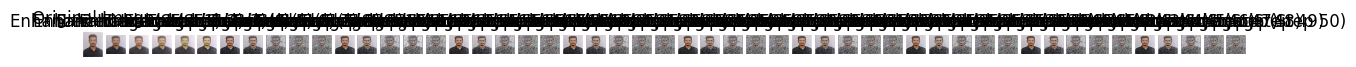

Total reward for episode 10: 2.97


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr

# Load a specific image from file
def load_image(image_path):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Resize image to 64x64 pixels
def resize_image(image, size=(64, 64)):
    return cv2.resize(image, size)

# Simulate some "enhancement" actions on the image
def apply_enhancement(image, action):
    if action == 0:
        # Simulate Gaussian blur
        enhanced_image = cv2.GaussianBlur(image, (3, 3), 0)  # Reduced blur
    elif action == 1:
        # Simulate contrast adjustment
        enhanced_image = cv2.convertScaleAbs(image, alpha=1.2, beta=0)  # Slightly increased contrast
    elif action == 2:
        # Simulate brightness increase
        enhanced_image = cv2.convertScaleAbs(image, alpha=1, beta=20)  # Slightly increased brightness
    elif action == 3:
        # Simulate sharpening
        kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
        enhanced_image = cv2.filter2D(image, -1, kernel)  # Sharpening filter
    elif action == 4:
        # Simulate color adjustment (Hue)
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        hsv[..., 0] = (hsv[..., 0] + 5) % 180  # Adjust hue slightly
        enhanced_image = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    # Resize to ensure consistent dimensions
    enhanced_image = resize_image(enhanced_image)

    # Convert to uint8 if necessary
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)  # Ensure proper data type

    # Debug: Print the shape of the enhanced image
    print(f"Enhanced Image Shape: {enhanced_image.shape}")  # Shape check
    return enhanced_image

# Define the environment for image enhancement
class SimpleImageEnhancementEnv:
    def __init__(self, image):
        self.image = image  # Original low-resolution image
        self.current_image = image.copy()
        self.action_space = 5  # Five actions defined now

    def step(self, action):
        # Apply the chosen enhancement action
        self.current_image = apply_enhancement(self.current_image, action)

        # Calculate PSNR between the enhanced and original image
        reward_psnr = psnr(self.current_image, self.image)

        # Calculate PNR ratio based on PSNR
        pnr_ratio = max(0, 1 / (1 + np.abs(reward_psnr - 30)))  # Example PNR ratio; adjust as needed

        # Print the PNR ratio for debugging
        print(f"PNR Ratio: {pnr_ratio:.4f}")  # Printing PNR Ratio

        # Calculate the final reward based on PSNR and PNR ratio
        final_reward = reward_psnr * pnr_ratio

        done = False  # Since this is a simple simulation, we'll not define a done condition

        return self.current_image, final_reward, done

    def reset(self):
        # Reset to the original image
        self.current_image = self.image.copy()
        return self.current_image

# Define a simple DQN network
class SimpleDQN(nn.Module):
    def __init__(self):
        super(SimpleDQN, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * 3, 128)  # Input layer (flattened image)
        self.fc2 = nn.Linear(128, 64)           # Hidden layer
        self.fc3 = nn.Linear(64, 5)             # Output layer (5 actions)

    def forward(self, x):
        x = x.reshape(x.size(0), -1)  # Flatten the image using reshape
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)  # Return action scores

# Initialize the DQN agent and optimizer
agent = SimpleDQN()
optimizer = optim.Adam(agent.parameters(), lr=0.001)

# Function to display images before and after enhancement
def plot_images(original_image, enhanced_images, episode):
    # Check if all images have the same dimensions
    shapes = [img.shape for img in enhanced_images]
    print(f"Shapes of enhanced images: {shapes}")  # Print all shapes

    if not all(shape == enhanced_images[0].shape for shape in shapes):
        raise ValueError("All enhanced images must have the same dimensions before plotting.")

    fig, axes = plt.subplots(1, len(enhanced_images) + 1, figsize=(15, 5))

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    # Enhanced images
    for i, enhanced_image in enumerate(enhanced_images):
        print(f"Plotting enhanced image {i + 1} with shape: {enhanced_image.shape}")  # Print shape before plotting
        axes[i + 1].imshow(enhanced_image)
        axes[i + 1].set_title(f'Enhanced Image (Step {i + 1})')
        axes[i + 1].axis('off')

    plt.show()

# Simulate multiple episodes for demonstration
def run_episodes(image_path, num_episodes=10):
    # Load the specific image to enhance
    original_image = load_image(image_path)

    # Resize the image to 64x64 pixels
    resized_image = resize_image(original_image)

    # Initialize the environment with this image
    env = SimpleImageEnhancementEnv(resized_image)

    # Store enhanced images for plotting later
    all_enhanced_images = []

    for episode in range(num_episodes):
        # Reset the environment (get the starting state, which is the original image)
        state = env.reset()

        total_reward = 0
        done = False
        steps = 5  # We'll limit the episode to 5 steps for this example

        for step in range(steps):
            # Convert the state (image) to a tensor and add a batch dimension
            state_tensor = torch.tensor(state, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Change to CxHxW

            # Get Q-values from the agent's network
            q_values = agent(state_tensor)

            # Select the action with the highest Q-value
            action = torch.argmax(q_values).item()

            # Step the environment using the selected action
            next_state, reward, done = env.step(action)

            # Accumulate the reward
            total_reward += reward

            # Calculate the loss (we'll assume the reward is the target Q-value for simplicity)
            optimizer.zero_grad()
            loss = torch.nn.functional.mse_loss(q_values[0, action], torch.tensor(reward, dtype=torch.float32))
            loss.backward()
            optimizer.step()

            # Update the state
            state = next_state

            # Store the enhanced image for plotting later
            all_enhanced_images.append(env.current_image)

        # Plot the original and enhanced images at the end of each episode
        plot_images(original_image, all_enhanced_images, episode + 1)

        print(f"Total reward for episode {episode + 1}: {total_reward:.2f}")

# Specify the path to your image here
image_path = '/content/imresizer-1727365402663.jpg'  # Change this to the path of your image file

# Run the simulation
run_episodes(image_path, num_episodes=10)
